# Teste ANOVA para o mercado financeiro

O objetivo dessa tarefa é fazer um teste de média entre as ações dentro da carteira montada no exercício de análise do mercado financeiro. Os detalhes dessa análise podem ser vistos aqui: https://github.com/demetriusjube/ppca-aedi/tree/master/mercado-financeiro.

Como definido lá, montamos uma carteira com as empresas que compõem o FAANG (Facebook, Amazon, Apple, Netflix e Google), juntamente com a Tesla, e utilizamos o índice do Banco de Nova York - BNY Mellon para comparação. Esperamos, assim, ver se há influência entre esses papeis e o a performance do banco. 

Os identificadores das empresas e do índice são os seguintes:
* Meta (antigo Facebook) - META
* Amazon - AMZN
* Apple - AAPL
* Netflix - NFLX
* Google - GOOGL
* Tesla - TSLA
* BNY Mellon - BK

## Montagem dos dados para realização do teste

O primeiro passo para isso é montar os dados da carteira. Os detalhes dessa montagem estão descritos no trabalho anterior, e não serão replicados aqui. O resultado final que buscamos é uma relação entre a taxa de retorno médio das ações e o retorno do índice NASDAQ, pois essa comparação que será alvo da ANOVA.

Importação das bibliotecas que serão usadas:

In [148]:
import pandas as pd
from pandas_datareader import data
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import seaborn as sns
from scipy import stats
from scipy import optimize
from scipy.stats import levene, bartlett, f, norm, f_oneway

pio.renderers.default = 'notebook_connected'

# Define as ações
acoes = ['META','AMZN', 'AAPL', 'NFLX', 'GOOGL', 'TSLA', 'BK']



Recuperação dos dados das ações da carteira:

In [149]:
# Recupera os dados das ações de 2015 até agora
acoes_df = pd.DataFrame()
for acao in acoes:
    acoes_df[acao] = data.DataReader(acao,
                                     data_source='yahoo', start='2015-01-01')['Close']

# Inclui um índice artificial no resultado das ações
acoes_df.reset_index(inplace=True)

acoes_df

,Date,META,AMZN,AAPL,NFLX,GOOGL,TSLA,BK
0,2015-01-02,78.449997,15.426000,27.332500,49.848572,26.477501,43.862000,40.459999
1,2015-01-05,77.190002,15.109500,26.562500,47.311428,25.973000,42.018002,39.419998
2,2015-01-06,76.150002,14.764500,26.565001,46.501431,25.332001,42.256001,38.279999
3,2015-01-07,76.150002,14.921000,26.937500,46.742859,25.257500,42.189999,39.070000
4,2015-01-08,78.180000,15.023000,27.972500,47.779999,25.345501,42.124001,39.610001
...,...,...,...,...,...,...,...,...
1908,2022-08-02,160.190002,134.160004,160.009995,221.419998,115.129997,901.760010,42.950001
1909,2022-08-03,168.800003,139.520004,166.130005,226.729996,118.080002,922.190002,43.709999
1910,2022-08-04,170.570007,142.570007,165.809998,229.910004,118.190002,925.900024,43.060001
1911,2022-08-05,167.110001,140.800003,165.350006,226.779999,117.470001,864.510010,43.500000


Montagem das taxas de retorno das ações:

In [150]:
dataset = acoes_df.copy()
# Retirando a coluna data, que não será usada no cálculo
dataset.drop(labels = ['Date'], axis=1, inplace=True)
# Inserção de uma linha para permitir a divisão da taxa de retorno do dia pelo dia anterior
taxas_retorno = np.log(dataset / dataset.shift(1))
taxas_retorno

,META,AMZN,AAPL,NFLX,GOOGL,TSLA,BK
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.016191,-0.020731,-0.028576,-0.052238,-0.019238,-0.042950,-0.026041
2,-0.013565,-0.023098,0.000094,-0.017269,-0.024989,0.005648,-0.029346
3,0.000000,0.010544,0.013925,0.005178,-0.002945,-0.001563,0.020427
4,0.026309,0.006813,0.037703,0.021946,0.003478,-0.001566,0.013727
...,...,...,...,...,...,...,...
1908,0.001624,-0.009126,-0.009331,-0.021402,0.002348,0.011073,-0.007885
1909,0.052354,0.039175,0.037534,0.023699,0.025300,0.022403,0.017540
1910,0.010431,0.021625,-0.001928,0.013928,0.000931,0.004015,-0.014982
1911,-0.020494,-0.012493,-0.002778,-0.013708,-0.006111,-0.068603,0.010166


Montagem das taxas de retorno com as respectivas datas:

In [151]:
dataset_date = acoes_df.copy()
date = dataset_date.filter(["Date"]) 
taxas_retorno_date = pd.concat([date, taxas_retorno], axis=1)
taxas_retorno_date = taxas_retorno_date.fillna(0)
taxas_retorno_date

,Date,META,AMZN,AAPL,NFLX,GOOGL,TSLA,BK
0,2015-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2015-01-05,-0.016191,-0.020731,-0.028576,-0.052238,-0.019238,-0.042950,-0.026041
2,2015-01-06,-0.013565,-0.023098,0.000094,-0.017269,-0.024989,0.005648,-0.029346
3,2015-01-07,0.000000,0.010544,0.013925,0.005178,-0.002945,-0.001563,0.020427
4,2015-01-08,0.026309,0.006813,0.037703,0.021946,0.003478,-0.001566,0.013727
...,...,...,...,...,...,...,...,...
1908,2022-08-02,0.001624,-0.009126,-0.009331,-0.021402,0.002348,0.011073,-0.007885
1909,2022-08-03,0.052354,0.039175,0.037534,0.023699,0.025300,0.022403,0.017540
1910,2022-08-04,0.010431,0.021625,-0.001928,0.013928,0.000931,0.004015,-0.014982
1911,2022-08-05,-0.020494,-0.012493,-0.002778,-0.013708,-0.006111,-0.068603,0.010166


Calculando a média das taxas de retorno da carteira para comparação com o Índice NASDAQ:

In [152]:
taxas_retorno_date["CARTEIRA"] = (taxas_retorno_date['META'] + taxas_retorno_date['AMZN'] + 
                                   taxas_retorno_date['AAPL'] + taxas_retorno_date['NFLX'] + 
                                   taxas_retorno_date['GOOGL'] +taxas_retorno_date['TSLA'] )/6
taxas_retorno_port = taxas_retorno_date.filter(["Date", "CARTEIRA", "BK"])
taxas_retorno_port = taxas_retorno_port.fillna(0)
taxas_retorno_port

,Date,CARTEIRA,BK
0,2015-01-02,0.000000,0.000000
1,2015-01-05,-0.029987,-0.026041
2,2015-01-06,-0.012196,-0.029346
3,2015-01-07,0.004190,0.020427
4,2015-01-08,0.015780,0.013727
...,...,...,...
1908,2022-08-02,-0.004136,-0.007885
1909,2022-08-03,0.033411,0.017540
1910,2022-08-04,0.008167,-0.014982
1911,2022-08-05,-0.020698,0.010166


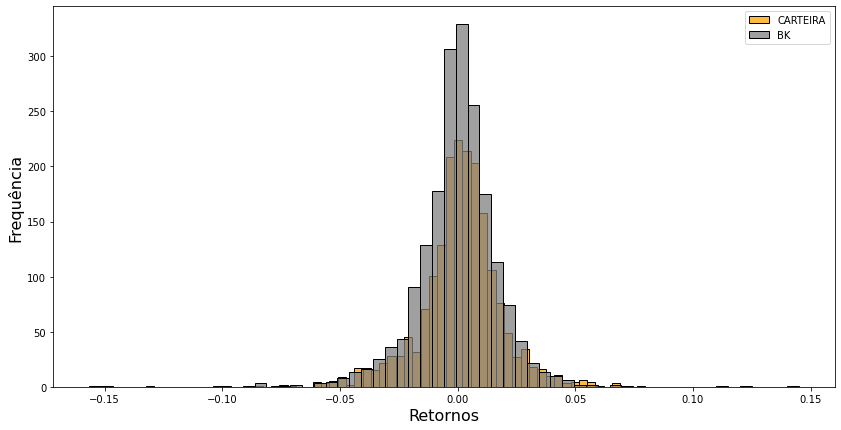

In [153]:
fig, ax = plt.subplots(figsize=(14,7))
# ax = sns.histplot(taxas_retorno_date['META'], bins=40, label='META', color = 'red')
# ax = sns.histplot(taxas_retorno_date['AMZN'], bins=40, label='AMZN', color='green')
# ax = sns.histplot(taxas_retorno_date['AAPL'], bins=40, label='AAPL', color='yellow')
# ax = sns.histplot(taxas_retorno_date['NFLX'], bins=40, label='NFLX', color='blue')
# ax = sns.histplot(taxas_retorno_date['GOOGL'], bins=40, label='GOOGL', color='orange')
ax = sns.histplot(taxas_retorno_date['CARTEIRA'], bins=60, label='CARTEIRA', color='orange')
ax = sns.histplot(taxas_retorno_date['BK'], bins=60, label='BK', color='gray')
ax.set_xlabel("Retornos",fontsize=16)
ax.set_ylabel("Frequência",fontsize=16)
plt.legend()

Com esses dados, poderemos checar as condições para saber se o teste ANOVA é viável.

## Teste da variâncias homogêneas ou homocedasticidade

Uma das premissas para realizar o teste da ANOVA é que as variâncias das amostras sejam homogêneas, ou seja:

$$
\sigma _{1}^2 = \sigma _{2}^2 =... = \sigma _{n}^2
$$

Para isso, existem dois tipos de teste para verificar essa homocedasticidade: O Teste de Levene e o Teste de Barlet.


### Teste de Levene

O Teste de Levene é uma estatística inferencial usada para avaliar a igualdade de variâncias de uma variável calculada para dois ou mais grupos. Ele testa a hipótese nula de que as variâncias populacionais são iguais (chamada de homogeneidade de variância ou homocedasticidade). Se o valor-p resultante do teste de Levene for menor que algum nível de significância (normalmente 0,05), é improvável que as diferenças obtidas nas variâncias amostrais tenham ocorrido com base na amostragem aleatória de uma população com variâncias iguais. Assim, a hipótese nula de variâncias iguais é rejeitada e conclui-se que há diferença entre as variâncias na população.


Então, vamos verificar se as variâncias são iguais nas combinações dos ativos que compõem a carteira:


In [154]:
nivel_significancia = 0.05

def getAmostra(ativo):
    return taxas_retorno_date[ativo]

def testaLevene(ativo1, ativo2):
    amostra1 = getAmostra(ativo1)
    amostra2 = getAmostra(ativo2)
    estatistica_teste, p_valor = levene(amostra1, amostra2)
    
    #print("Estatística-teste:",ativo1," x ", ativo2, estatistica_teste)
    #print("P-valor:", p_valor)
    teste = ativo1 + " x " + ativo2
    resultado = ""
    if p_valor <= nivel_significancia:
        resultado = "Rejeita H0 - Variâncias não são iguais"
    else:
        resultado = "Não Rejeita H0 - Variâncias são iguais"
    return (teste, p_valor.round(5), resultado)

resultadoTesteLevene = []
acoesTeste = acoes.copy()
for acaoLinha in acoesTeste:
    resultadoTesteLevene.append(testaLevene('CARTEIRA',acaoLinha))

resultadoTesteLeveneDf = pd.DataFrame(resultadoTesteLevene, columns=['Teste', 'P-value', 'Resultado']);
# resultadoDf.query("Resultado == 'Não Rejeita H0 - Variâncias são iguais'")
resultadoTesteLeveneDf.sort_values(by='P-value')

,Teste,P-value,Resultado
3,CARTEIRA x NFLX,0.00000,Rejeita H0 - Variâncias não são iguais
5,CARTEIRA x TSLA,0.00000,Rejeita H0 - Variâncias não são iguais
0,CARTEIRA x META,0.00001,Rejeita H0 - Variâncias não são iguais
1,CARTEIRA x AMZN,0.00257,Rejeita H0 - Variâncias não são iguais
4,CARTEIRA x GOOGL,0.13937,Não Rejeita H0 - Variâncias são iguais
2,CARTEIRA x AAPL,0.30537,Não Rejeita H0 - Variâncias são iguais
6,CARTEIRA x BK,0.47581,Não Rejeita H0 - Variâncias são iguais


Com esse resultado, identificamos que a Carteira tem relação homocedástica com o índice BK, além do Google e da Apple. Vamos confirmar essa hipótese com o Teste de Bartlett. Ele também tem como objetivo descartar a hipótese nula de que as variâncias são iguais:

In [155]:
def testaBartlett(ativo1, ativo2):
    amostra1 = getAmostra(ativo1)
    amostra2 = getAmostra(ativo2)
    estatistica_teste, p_valor = bartlett(amostra1, amostra2)
    
    #print("Estatística-teste:",ativo1," x ", ativo2, estatistica_teste)
    #print("P-valor:", p_valor)
    teste = ativo1 + " x " + ativo2
    resultado = ""
    if p_valor <= nivel_significancia:
        resultado = "Rejeita H0 - Variâncias não são iguais"
    else:
        resultado = "Não Rejeita H0 - Variâncias são iguais"
    return (teste, p_valor.round(5), resultado)

resultadoTesteBartlett = []
for acaoLinha in acoesTeste:
    resultadoTesteBartlett.append(testaBartlett('CARTEIRA',acaoLinha))

resultadoBartlettDf = pd.DataFrame(resultadoTesteBartlett, columns=['Teste', 'P-value', 'Resultado']);
# resultadoDf.query("Resultado == 'Não Rejeita H0 - Variâncias são iguais'")
resultadoBartlettDf.sort_values(by='P-value')

,Teste,P-value,Resultado
0,CARTEIRA x META,0.00000,Rejeita H0 - Variâncias não são iguais
1,CARTEIRA x AMZN,0.00000,Rejeita H0 - Variâncias não são iguais
3,CARTEIRA x NFLX,0.00000,Rejeita H0 - Variâncias não são iguais
5,CARTEIRA x TSLA,0.00000,Rejeita H0 - Variâncias não são iguais
2,CARTEIRA x AAPL,0.10960,Não Rejeita H0 - Variâncias são iguais
4,CARTEIRA x GOOGL,0.15546,Não Rejeita H0 - Variâncias são iguais
6,CARTEIRA x BK,0.94988,Não Rejeita H0 - Variâncias são iguais


De forma gráfica, podemos verificar que a dispersão entre os ativos homocedásticos é muito similar, enquanto nos heterocedásticos, há uma dispersão maior:

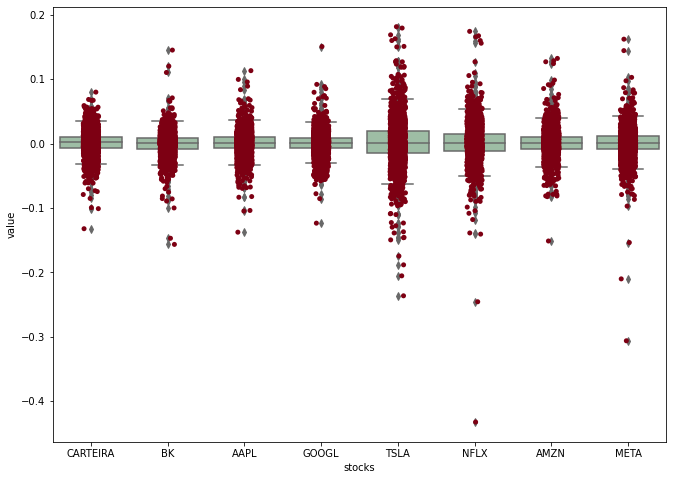

In [156]:
plt.figure(figsize =(11, 8))
df_melt = pd.melt(taxas_retorno_date.reset_index(), id_vars=['index'], value_vars=['CARTEIRA','BK','AAPL','GOOGL', 'TSLA', 'NFLX', 'AMZN', 'META'])
df_melt.columns = ['index', 'stocks', 'value']

ax = sns.boxplot(x='stocks', y='value', data=df_melt, color='#99c2a2')
ax = sns.stripplot(x="stocks", y="value", data=df_melt, color='#7d0013')
plt.show()

## Teste ANOVA

Uma vez que a condição de homogeneidade das variâncias foi satisfeita, podemos fazer o teste ANOVA, para identificar se a média das ações é igual. As hipóteses que serão verificadas serão as seguintes:


H_0: $$\mu _{0} = \mu _{1} = ... = \mu _{n}$$
H_1: Há diferença entre as médias



In [157]:
analise_df_melted = pd.melt(taxas_retorno_date, id_vars=["Date"], value_vars=["CARTEIRA", "BK"])
analise_df_melted.columns = ["Data de Negociação", "Tipo", "Taxa de Retorno"]
analise_df_melted

,Data de Negociação,Tipo,Taxa de Retorno
0,2015-01-02,CARTEIRA,0.000000
1,2015-01-05,CARTEIRA,-0.029987
2,2015-01-06,CARTEIRA,-0.012196
3,2015-01-07,CARTEIRA,0.004190
4,2015-01-08,CARTEIRA,0.015780
...,...,...,...
3821,2022-08-02,BK,-0.007885
3822,2022-08-03,BK,0.017540
3823,2022-08-04,BK,-0.014982
3824,2022-08-05,BK,0.010166


In [158]:
# Create ANOVA backbone table
data = [["Entre grupos", "", "", "", "", "", ""], ["Dentro dos grupos", "", "", "", "", "", ""], ["Total", "", "", "", "", "", ""]]
anova_table = pd.DataFrame(data, columns = ["Fonte da Variação", "SS", "df", "MS", "F", "P-value", "F crit"])
anova_table.set_index("Fonte da Variação", inplace = True)

# calculate SSTR and update anova table
x_bar = analise_df_melted["Taxa de Retorno"].mean()
SSTR = analise_df_melted.groupby("Tipo").count() * (analise_df_melted.groupby("Tipo").mean() - x_bar)**2
anova_table["SS"]["Entre grupos"] = SSTR["Taxa de Retorno"].sum()

# calculate SSE and update anova table
SSE = (analise_df_melted.groupby("Tipo").count() - 1) * analise_df_melted.groupby("Tipo").std()**2
anova_table["SS"]["Dentro dos grupos"] = SSE["Taxa de Retorno"].sum()

# calculate SSTR and update anova table
SSTR = SSTR["Taxa de Retorno"].sum() + SSE["Taxa de Retorno"].sum()
anova_table["SS"]["Total"] = SSTR

# update degree of freedom
anova_table["df"]["Entre grupos"] = analise_df_melted["Tipo"].nunique() - 1
anova_table["df"]["Dentro dos grupos"] = analise_df_melted.shape[0] - analise_df_melted["Tipo"].nunique()
anova_table["df"]["Total"] = analise_df_melted.shape[0] - 1

# calculate MS
anova_table["MS"] = anova_table["SS"] / anova_table["df"]

# calculate F
F = anova_table["MS"]["Entre grupos"] / anova_table["MS"]["Dentro dos grupos"]
anova_table["F"]["Entre grupos"] = F

# p-value
anova_table["P-value"]["Entre grupos"] = 1 - f.cdf(F, anova_table["df"]["Entre grupos"], anova_table["df"]["Dentro dos grupos"])

# F critical
alpha = 0.05
# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table["F crit"]["Entre grupos"] = f.ppf(1-alpha, anova_table["df"]["Entre grupos"], anova_table["df"]["Dentro dos grupos"])

# Final ANOVA Table
anova_table

,SS,df,MS,F,P-value,F crit
Fonte da Variação,,,,,,
Entre grupos,0.000788,1,0.000788,2.446863,0.117843,5.027845
Dentro dos grupos,1.231551,3824,0.000322,,,
Total,1.232339,3825,0.000322,,,


In [159]:
stat_teste, p_valor = f_oneway(taxas_retorno_date["CARTEIRA"], taxas_retorno_date["BK"])

if p_valor <= nivel_significancia:
    print("Rejeita H0 - Médias não são iguais")
else:
    print("Não Rejeita H0 - Médias são iguais")

Não Rejeita H0 - Médias são iguais


Dessa forma, podemos verificar que a média da `CARTEIRA` e da `BK` são iguais, estatisticamente.